In [88]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from pyquaternion import Quaternion

In [62]:
Tmax = 0.000953
Wmax = 1570.79632679
Vmax = 6
a_1 = np.array([[1],[0],[0]])
a_2 = np.array([[0],[1],[0]])
a_3 = np.array([[0],[0],[1]])
a_mat = np.concatenate((a_1, a_2, a_3), axis=1)
I = np.array([[0.04, 0.00, 0.00],
              [0.00, 0.05, 0.02],
              [0.00, 0.02, 0.05]])
I_inv = np.linalg.inv(I)
I_rw = 6.25E-05
I_wheels = I_rw*(a_1*np.transpose(a_1) + a_2*np.transpose(a_2) + a_3*np.transpose(a_3))

In [63]:
def dynamics(x, u):
    q = x[0:4, :]
    w = x[4:7, :]
    Omega = x[7:10, :]
    V = u
    return ca.vertcat(
        -w[0]*q[1]-w[1]*q[2]-w[2]*q[3], # Quaternion dynamics
        w[0]*q[0] +w[1]*q[3]-w[2]*q[2],
        -w[0]*q[3]+w[1]*q[0]+w[2]*q[1],
        w[0]*q[2] -w[1]*q[1]+w[2]*q[0],
        -(Tmax/Vmax)*a_mat@V + (Tmax/Wmax)*a_mat@Omega - # Angular dynamics
            ca.cross(w, (I@w) + (I_wheels@w) + I_rw*(a_mat@Omega)),
        (Tmax/(Vmax*I_rw))*V - (Tmax/(Wmax*I_rw))*Omega - a_mat.T@w # RW Velocities
    )

In [74]:
N = 400  # Number of control intervals
opti = ca.Opti()

# State variables
X = opti.variable(4 + 3 + 3, N + 1)
q = X[0:4, :]
w = X[4:7, :]
Omega = X[7:10, :]

# Control variables
U = opti.variable(3, N) # 3 inputs

# Total time variable
T = opti.variable()
dt = T / N  # length of one control interval

# Minimize time
opti.minimize(T)

# Apply dynamic constriants
for k in range(N):
    x_next = X[:, k] + dynamics(X[:, k], U[:, k]) * dt
    opti.subject_to(X[:, k + 1] == x_next)

# Apply input constraints
opti.subject_to(
    opti.bounded(-6, U, 6) # May need to make it multivariate
)

# Other constraints
# for k in range(N + 1):
#     opti.subject_to(q[0, k]**2 + q[1, k]**2 + q[2, k]**2 + q[3, k]**2 == 1)

# Boundary conditions
# Start
opti.subject_to(q[0, 0] == 1)
opti.subject_to(q[1, 0] == 0)
opti.subject_to(q[2, 0] == 0)
opti.subject_to(q[3, 0] == 0)
opti.subject_to(w[0, 0] == 0)
opti.subject_to(w[1, 0] == 0)
opti.subject_to(w[2, 0] == 0)
opti.subject_to(Omega[0, 0] == 0)
opti.subject_to(Omega[1, 0] == 0)
opti.subject_to(Omega[2, 0] == 0)
opti.subject_to(U[0, 0] == 0)
opti.subject_to(U[1, 0] == 0)
opti.subject_to(U[2, 0] == 0)

# End
opti.subject_to(q[0, -1] == -0.0434363)
opti.subject_to(q[1, -1] == -0.5855824)
opti.subject_to(q[2, -1] == -0.7539713)
opti.subject_to(q[3, -1] == -0.2945059)
opti.subject_to(w[0, -1] == 0)
opti.subject_to(w[1, -1] == 0)
opti.subject_to(w[2, -1] == 0)
opti.subject_to(Omega[0, -1] == 0)
opti.subject_to(Omega[1, -1] == 0)
opti.subject_to(Omega[2, -1] == 0)
opti.subject_to(U[0, -1] == 0)
opti.subject_to(U[1, -1] == 0)
opti.subject_to(U[2, -1] == 0)

# Time constraints
opti.subject_to(T >= 0)
 
# Initial guess
opti.set_initial(q[0], 1)
opti.set_initial(q[1], 0)
opti.set_initial(q[2], 0)
opti.set_initial(q[3], 0)
opti.set_initial(w[0], 0)
opti.set_initial(w[1], 0)
opti.set_initial(w[2], 0)
opti.set_initial(Omega[0], 0)
opti.set_initial(Omega[1], 0)
opti.set_initial(Omega[2], 0)
opti.set_initial(U, 0)
opti.set_initial(U, 0)
opti.set_initial(U, 0)

In [75]:
opti.solver("ipopt", {}, {"mu_init": 1e-3})  # set numerical backen

In [76]:
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    36026
Number of nonzeros in inequality constraint Jacobian.:     1201
Number of nonzeros in Lagrangian Hessian.............:    16000

Total number of variables............................:     5211
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4026
Total number of inequality constraints...............:     1201
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:     1200
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 1.00e+00  -3.0 0.00e+00    -  0.00e+00 0.00e+00 

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:996: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'

In [77]:
opti.debug.value(q[:, -1])
# opti.subject_to(q[0, -1] == -0.0434363)
# opti.subject_to(q[1, -1] == -0.5855824)
# opti.subject_to(q[2, -1] == -0.7539713)
# opti.subject_to(q[3, -1] == -0.2945059)

array([-0.04084068, -0.58412573, -0.75209575, -0.2937733 ])

In [78]:
opti.debug.value(T)

0.00815289783591935

In [79]:
np.max(opti.debug.value(U))

0.000260494616350982

In [80]:
np.linalg.norm(opti.debug.value(q[:, -1]))

0.997407440295721

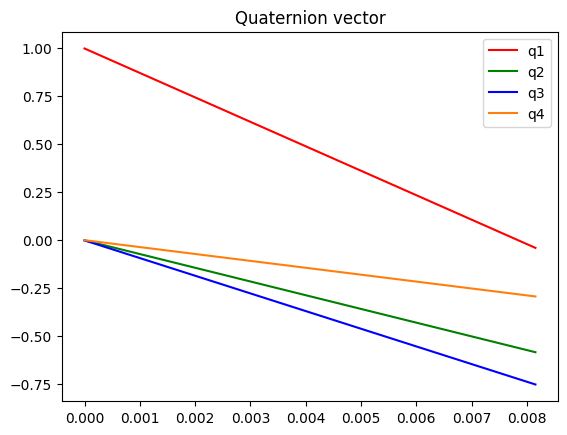

In [84]:
tsa = np.linspace(0, opti.debug.value(T), N+1)
qa = opti.debug.value(q)

%matplotlib inline
plt.title('Quaternion vector')
plt.plot(tsa, qa[0,:], 'r', label='q1')
plt.plot(tsa, qa[1,:], 'g', label='q2')
plt.plot(tsa, qa[2,:], 'b', label='q3')
plt.plot(tsa, qa[3,:], 'tab:orange', label='q4')
plt.legend()
plt.show()

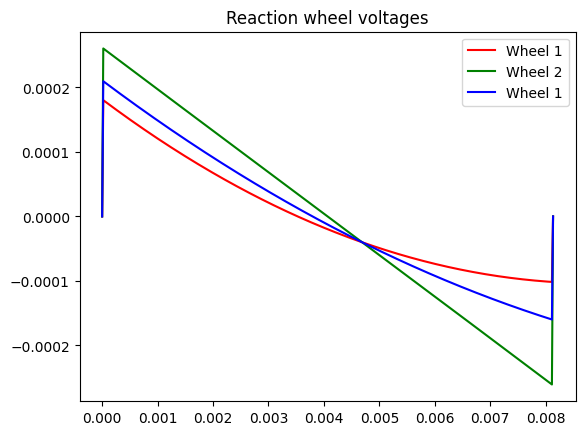

In [83]:
%matplotlib inline

Vb = opti.debug.value(U)
tsb = tsa[:-1]

plt.title("Reaction wheel voltages")
plt.plot(tsb, Vb[0,:], 'r', label="Wheel 1")
plt.plot(tsb, Vb[1,:], 'g', label="Wheel 2")
plt.plot(tsb, Vb[2,:], 'b', label="Wheel 1")
plt.legend()
plt.show()

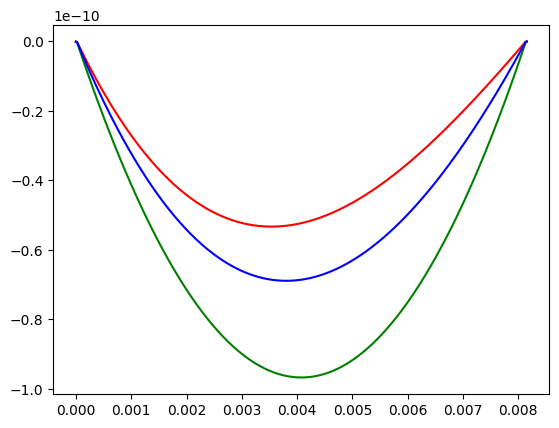

In [82]:
%matplotlib inline

wc = opti.debug.value(w)

plt.plot(tsa, wc[0,:], 'r')
plt.plot(tsa, wc[1,:], 'g')
plt.plot(tsa, wc[2,:], 'b')
plt.show()

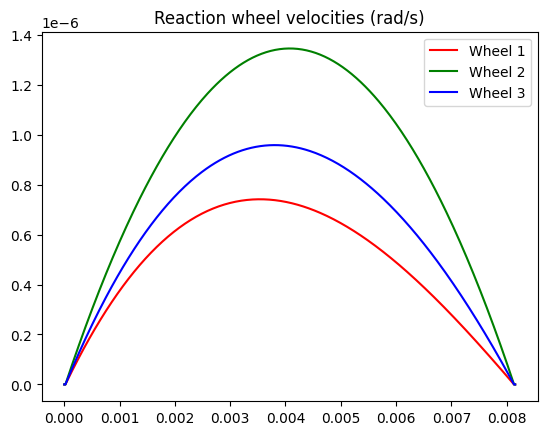

In [86]:
%matplotlib inline

Omegad = opti.debug.value(Omega)

plt.title("Reaction wheel velocities (rad/s)")
plt.plot(tsa, Omegad[0,:], 'r', label="Wheel 1")
plt.plot(tsa, Omegad[1,:], 'g', label="Wheel 2")
plt.plot(tsa, Omegad[2,:], 'b', label="Wheel 3")
plt.legend()
plt.show()

In [94]:
quat_desired = Quaternion(np.array([-0.0434363, -0.5855824, -0.7539713, -0.2945059]))

In [95]:
err = []
for i in range(0, qa.shape[1]):
    quat_cur = Quaternion(qa[:,i])
    err.append(2*np.arccos((quat_cur.conjugate*quat_desired).real)*180/np.pi)

<IPython.core.display.Javascript object>


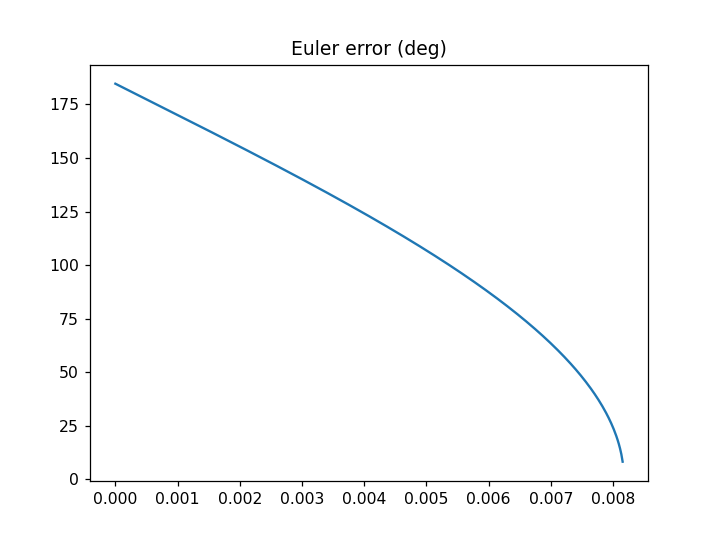

[]

In [96]:
%matplotlib notebook
plt.plot(tsa, err)
plt.title("Euler error (deg)")
plt.plot()